**Install libraries**



In [4]:
!pip install -q transformers torch torchvision pillow opencv-python matplotlib


**Enable and Check GPU is available**

In [5]:
import torch

print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


GPU available: True
GPU name: Tesla T4


# Explainable OCR using TrOCR

Goal:
- Run OCR using pretrained TrOCR
- Extract cross-attention during inference
- Visualize attention heatmaps over image regions


In [6]:
from google.colab import files
uploaded = files.upload()


Saving sample.jpg to sample.jpg


**Imports**

In [7]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch


**LOAD PRETRAINED TrOCR MODEL**

In [8]:
processor = TrOCRProcessor.from_pretrained(
    "microsoft/trocr-base-printed"
)

model = VisionEncoderDecoderModel.from_pretrained(
    "microsoft/trocr-base-printed"
)

model.to("cuda")
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

**LOAD IMAGE**

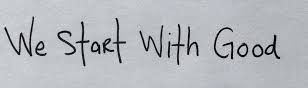

In [9]:
image = Image.open("sample.jpg").convert("RGB")
image


**IMAGE PREPROCESSING**

In [10]:
pixel_values = processor(
    images=image,
    return_tensors="pt"
).pixel_values

pixel_values = pixel_values.to("cuda")


**OCR INFERENCE**

In [11]:
with torch.no_grad():
    generated_ids = model.generate(pixel_values)

predicted_text = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True
)[0]

print("OCR Output:")
print(predicted_text)


OCR Output:
WE START WITH GOOD


**Model with attention outputs**

In [12]:
with torch.no_grad():
    outputs = model(
        pixel_values,
        decoder_input_ids=generated_ids,
        output_attentions=True,
        return_dict=True
    )


/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:1014: UserWarning: `output_attentions=True` is not supported with `attn_implementation` other than ['eager', 'eager_paged', 'flex_attention']. Please use `model.set_attn_implementation('eager')` to enable capturing attention outputs.
  warnings.warn(


**Inspect attention shape**

In [13]:
print("Number of decoder layers:", len(outputs.cross_attentions))
print("Shape of one layer attention:", outputs.cross_attentions[0].shape)


Number of decoder layers: 12
Shape of one layer attention: torch.Size([1, 16, 6, 577])


**Combine layers & heads**

In [14]:
import torch

# Stack all decoder layers
attentions = torch.stack(outputs.cross_attentions)
# (layers, batch, heads, tokens, patches)

# Average over layers and heads
attn_mean = attentions.mean(dim=0).mean(dim=1)
# shape: (batch, tokens, patches)

attn_mean.shape


torch.Size([1, 6, 577])

In [15]:
####
tokens = processor.tokenizer.convert_ids_to_tokens(
    generated_ids[0]
)

for i, tok in enumerate(tokens):
    print(i, tok)
####

0 </s>
1 WE
2 ĠSTART
3 ĠWITH
4 ĠGOOD
5 </s>


**ONE token to visualize**

In [16]:
token_index = 1  # skip <s> token
token_attention = attn_mean[0, token_index]


**Convert patches → 2D grid**

In [24]:
import numpy as np

num_patches = token_attention.shape[0]
grid_size = int(np.sqrt(num_patches))

attention_map = token_attention.reshape(grid_size, grid_size).cpu().numpy()

print("Attention grid shape:", attention_map.shape)


Attention grid shape: (24, 24)


**Resize attention to image size**

In [25]:
import cv2

attention_map = cv2.resize(
    attention_map,
    image.size
)


**Normalize & overlay heatmap**

array([[[223, 136, 126],
        [223, 136, 126],
        [223, 136, 126],
        ...,
        [184, 114, 117],
        [184, 114, 117],
        [184, 114, 117]],

       [[223, 136, 126],
        [223, 136, 126],
        [223, 136, 126],
        ...,
        [179, 109, 112],
        [179, 109, 112],
        [179, 109, 112]],

       [[223, 129, 126],
        [223, 129, 126],
        [223, 129, 126],
        ...,
        [175, 107, 110],
        [175, 107, 110],
        [175, 107, 110]],

       ...,

       [[221, 163, 124],
        [221, 163, 124],
        [221, 163, 124],
        ...,
        [206, 109, 112],
        [206, 109, 112],
        [206, 109, 112]],

       [[221, 169, 124],
        [221, 169, 124],
        [221, 169, 124],
        ...,
        [210, 113, 113],
        [210, 113, 113],
        [210, 113, 113]],

       [[221, 169, 124],
        [221, 169, 124],
        [221, 169, 124],
        ...,
        [211, 114, 114],
        [211, 114, 114],
        [211, 114, 114]]], dtype=uint8)
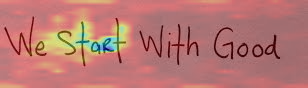

In [26]:
# Normalize
attention_map = (attention_map - attention_map.min()) / (
    attention_map.max() - attention_map.min() + 1e-8
)

heatmap = cv2.applyColorMap(
    np.uint8(255 * attention_map),
    cv2.COLORMAP_JET
)

overlay = cv2.addWeighted(
    np.array(image),
    0.6,
    heatmap,
    0.4,
    0
)

overlay


**Decode tokens properly**

In [27]:
# Decode tokens individually
tokens = processor.tokenizer.convert_ids_to_tokens(
    generated_ids[0]
)

tokens


['</s>', 'WE', 'ĠSTART', 'ĠWITH', 'ĠGOOD', '</s>']

**Loop through tokens & visualize attention**

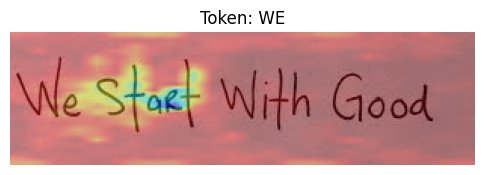

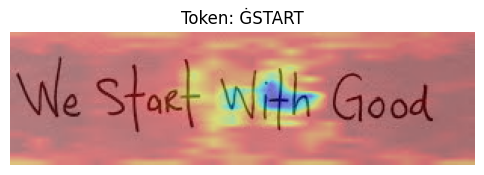

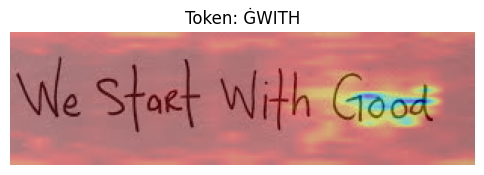

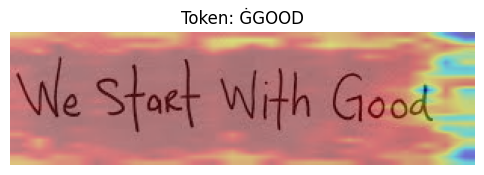

In [29]:
import matplotlib.pyplot as plt

for idx, token in enumerate(tokens):
    if token in ["<s>", "</s>"]:
        continue

    token_attention = attn_mean[0, idx][1:]  # remove CLS token

    # Convert to grid
    attention_map = token_attention.reshape(grid_size, grid_size).cpu().numpy()
    attention_map = cv2.resize(attention_map, image.size)

    # Normalize
    attention_map = (attention_map - attention_map.min()) / (
        attention_map.max() - attention_map.min() + 1e-8
    )

    heatmap = cv2.applyColorMap(
        np.uint8(255 * attention_map),
        cv2.COLORMAP_JET
    )

    overlay = cv2.addWeighted(
        np.array(image),
        0.6,
        heatmap,
        0.4,
        0
    )

    # Show result
    plt.figure(figsize=(6,3))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Token: {token}")
    plt.show()
